# M-Lab Data Analysis Notebook

An autonomous system number (ASN) is a unique number assigned to an autonomous system(AS) by the Internet Assigned Numbers Authority (IANA).

An AS consists of blocks of IP addresses which have a distinctly defined policy for accessing external networks and are administered by a single organization but may be made up of several operators.

IPs of Starlink User Terminals have the ASN of `14593`

Also see:
- https://www.peeringdb.com/net/18747
- https://www.measurementlab.net/data/


I currently am using the [BigQuery interface](https://console.cloud.google.com/bigquery?project=measurement-lab&pli=1) to get the M-Lab data. The query result are then downloaded to the `./data/mlab_starlink_data` folder as a .csv file and used by the following scripts. The `./data/mlab_starlink_data/README.md` stores the used queries.

---

**Why not use the API?**

Because of this ([source](https://www.measurementlab.net/data/docs/bq/quickstart/)):

> [...] Because of the means by which M-Lab must whitelist query users, we cannot guarantee that no charges will be incurred by applications using service accounts which query M-Lab datasets, tables, and views.

**Retrieving the mlab data**

```bash
cd /path/to/this/notebook
cd data
wget https://syncandshare.lrz.de/dl/fiXT6TrDAYGGsK6To7v75K/mlab_starlink_data.zip
unzip mlab_starlink_data.zip
```

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geohash
import cartopy.crs as ccrs
from datetime import datetime

In [108]:
# Starlink Availability scraped from wikipedia

from bs4 import BeautifulSoup
import requests

response = requests.get("https://en.wikipedia.org/wiki/Starlink")
soup = BeautifulSoup(response.text)

countries_soup = soup.find_all("table", attrs={"class": "wikitable"})[1]

countries = []
for a in countries_soup.find_all("tr")[1:]:
    for b in a.find_all("td")[2].find_all("a"):
        countries.append(b.text)

## Monthly Probe Count

In [134]:
ndt7_df   = pd.read_csv("./data/mlab_starlink_data/ndt7_tableentrystats.csv").set_index("month")

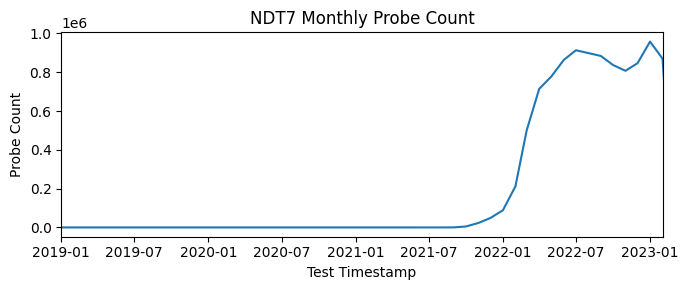

In [137]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(
    [datetime.fromisoformat(dt) for dt in ndt7_df.index],
    ndt7_df["entry_count"]
)
ax.set_xlim(
    datetime.fromisoformat(ndt7_df.index[0]),
    datetime.fromisoformat(ndt7_df.index[-2])
)
ax.set_ylabel("Probe Count")
ax.set_xlabel("Test Timestamp")
plt.title("NDT7 Monthly Probe Count")
plt.tight_layout()
#plt.savefig("temp.pdf", pad_inches=0)
plt.show()

## Cities Overview

In [139]:
import geohash
import geopandas
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from matplotlib import colors
from descartes import PolygonPatch

In [140]:
ndt7_df   = pd.read_csv("./data/mlab_starlink_data/ndt7_cities_overview.csv").set_index("ClientGeohash")
ndt7_df = ndt7_df.sort_values(by="MeasurementCount", ascending=False)
ndt7_df["lat"] = [geohash.decode(gh)[0] for gh in ndt7_df.index]
ndt7_df["lon"] = [geohash.decode(gh)[1] for gh in ndt7_df.index]

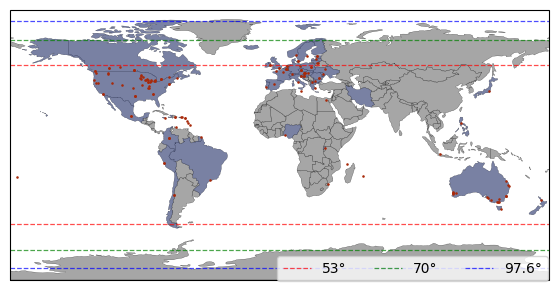

In [154]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world = world[(world.name!="Antarctica")]

def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.4, zorder=2, linewidth=0.0 ))


fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "grey", edgecolor="black", ax=ax, linewidth=0.2, alpha=0.7, zorder=0)

for c in countries:
    c = "United States of America" if c == "United States" else c
    c = "Czechia" if c == "Czech Republic" else c
    
    if(c in world["name"].values):
        plotCountryPatch(ax, c, "#364aa0")
    #else:
    #    print(c)

def plot_extent(inclination, color="r", lw=0.9, alpha=0.7):
    label = "{}°".format(inclination)
    if inclination > 90:
        inclination = 90 - (inclination % 90)
    plt.plot([-180, 180], [ inclination,  inclination], linewidth=lw, color=color, linestyle="dashed", alpha=alpha, label=label)
    plt.plot([-180, 180], [-inclination, -inclination], linewidth=lw, color=color, linestyle="dashed", alpha=alpha)

plot_extent(53, "r")
plot_extent(70, "g")
plot_extent(97.6, "b")

#for x, y, label in zip(ndt7_df["lon"], ndt7_df["lat"], ndt7_df["ClientCountry"]):
#    ax.annotate(
#                    label,
#                    xy=(x, y),
#                    xytext=(2, 2),
#                    textcoords="offset points",
#                    fontsize=5
#    )
        
latitude, longitude = ndt7_df["lat"], ndt7_df["lon"]
ax.scatter(longitude, latitude, 
               sizes = [0.7],
               color="#a8290a",
               zorder = 10)

plt.legend(loc='lower right', bbox_to_anchor=(1.01, -0.03),
          ncol=3, fancybox=True, shadow=False)

ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig("temp.png", dpi=300)
plt.show()

In [171]:
# Countries Outside of 53° latitude region. However: no probe is from outside of 53° coverage
ndt7_df[ndt7_df["lat"] > 53]["ClientCountry"]

ClientGeohash
gc7x3      Ireland
gc7x3      Ireland
u4xst       Norway
u6sce       Sweden
u3buy      Denmark
ud9d4      Estonia
ud15u       Latvia
u9dp0    Lithuania
u3buw      Denmark
u99zp    Lithuania
ud9d4      Estonia
Name: ClientCountry, dtype: object

## Analysis Idea

- Choose Countries with different Orbital Properties
    - 

- Plot throughput/latency for each continent/country/states
  - How do choose countries? Some countries with different relationships to the orbital planes (inclination or other parameters)
  
- Timewise Analysis (country/continent)
  - Throughput Latency change from 2021/2022
    - How does this relate to orbital shells?
  - Correlate to new launches?



In [3]:
df = pd.read_csv("./mlab_starlink_data/raw_ndt7_cities1.csv")

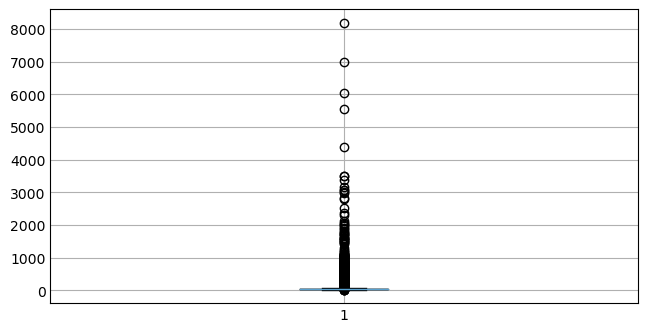

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
#np.random.seed(10)
#arr1 = np.random.normal(5, 1, size=(10,))
#arr2 = np.random.normal(3, 3, size=(10,))
#arr3 = np.random.normal(10, 0.3, size=(10,))
#arr4 = np.random.normal(4, 5, size=(10,))

#columns = [
#    df[df["ClientCity"] == "Mexico City"]["MinRTT"],
#    df[df["ClientCity"] == "Bogotá"]["MinRTT"],
#    df[df["ClientCity"] == "Oslo"]["MinRTT"],
#    df[df["ClientCity"] == "Seattle"]["MinRTT"],
#    df[df["ClientCity"] == "Sydney"]["MinRTT"]
#]

columns = [df[(df["ClientCity"] == "Berlin") & (df["MinRTT"] < 100000)]["MinRTT"]]

fig, ax = plt.subplots(figsize=(6, 3))
ax.boxplot(columns)
plt.show()

In [5]:
#df = pd.read_csv("./mlab_starlink_data/ndt7_city2fivenumbersummary.csv")
df = pd.read_csv("./mlab_starlink_data/ndt7_city2fivenumbersummary.csv")
df = df.set_index("City")
df = df.loc[[
            "Mexico City",
            "Bogotá",
            "Oslo",
            "Seattle",
            "Sydney",
            "Chicago",
            "Denver",
            "Toronto",
            "Calgary",
            "Berlin"
            ]]

In [6]:
df.columns

Index(['measurement_count', 'avg_latitude', 'avg_longitude',
       'MeanThroughputMbps_stddev', 'MinRTT_stddev', 'lossrate_stddev',
       'MeanThroughputMbps_q0', 'MeanThroughputMbps_q1',
       'MeanThroughputMbps_q2', 'MeanThroughputMbps_q3',
       'MeanThroughputMbps_q4', 'MinRTT_q0', 'MinRTT_q1', 'MinRTT_q2',
       'MinRTT_q3', 'MinRTT_q4', 'lossrate_q0', 'lossrate_q1', 'lossrate_q2',
       'lossrate_q3', 'lossrate_q4'],
      dtype='object')

In [7]:
def row2box(row, attr, usestd = True):
    median = row["{}_q2".format(attr)]
    
    if(usestd):
        q0 = median - row["{}_stddev".format(attr)]
        q0 = 0 if q0 < 0 else q0
        q4 = median + row["{}_stddev".format(attr)]
    else:
        q0 = row["{}_q0".format(attr)]
        q0 = 0 if q0 < 0 else q0
        q4 = row["{}_q4".format(attr)]
        q4 = row["{}_q3".format(attr)]
    
    return {
        'label' : row.name,
        'whislo': q0,# Bottom whisker position
        'q1'    : row["{}_q1".format(attr)],             # First quartile (25th percentile)
        'med'   : median,                                # Median         (50th percentile)
        'q3'    : row["{}_q3".format(attr)],             # Third quartile (75th percentile)
        'whishi': q4,    # Top whisker position
        'fliers': []                                     # Outliers
    }

def visualize_boxplot(df, attr, save=False, usestd=True):
    fig, ax = plt.subplots(figsize=(6, 3))
    boxes = [row2box(row, attr, usestd=usestd) for idx, row in df.iterrows()]
    ax.bxp(boxes, showfliers=False)
    
    if(attr == "MeanThroughputMbps"):
        ax.set_ylabel("Mean Throughput in Mbps")
    elif(attr == "MinRTT"):
        ax.set_ylabel("Min RTT in milliseconds")
    elif(attr == "lossrate"):
        ax.set_ylabel("Lossrate from the lifetime of the connection")
    
    if(save):
        plt.tight_layout()
        plt.savefig("mlab_{}_starlink_boxplot.pdf".format(attr))
    plt.show()
    
    
# [x] Filter Edge-Cases:
    # MinRTT = -1
    # Meanthroughput = 0.0
    # lossrate = -1
# [ ] Inverstigate Max value, put those into outliers
    # Maximum values are probably better in a spearate plot
# TODO: [x] Use Standard Deviation instead of Maximum/Minimum
# [ ] Compare throughput latencies reported over Cellular Networks with the ones over Starlink
    # https://github.com/tkdang97/Cloudy-with-a-Chance-of-Short-RTTs/blob/main/speedchecker-analysis.ipynb
    # Associated Dataset
        # Compare ISPs by looking at probes that connect to the same endpoint
            # Throughput, Latency/RTT
        # Use above information to compare the ISP to Starlink
# [ ] Sync Throughput Count Map with availability
# 


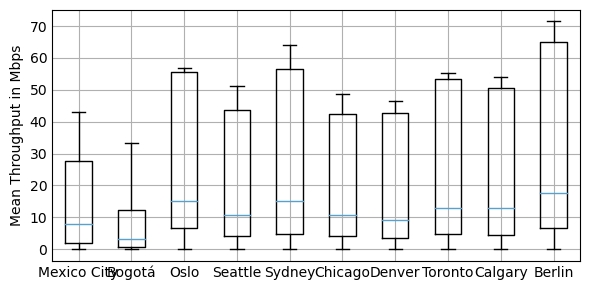

In [8]:
visualize_boxplot(df, "MeanThroughputMbps", save=True)

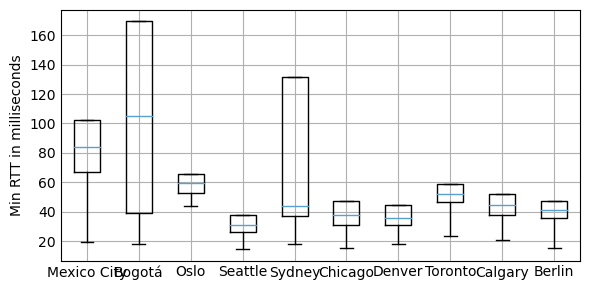

In [11]:
# This might be a bit interesting as CDF
#   - 75th percentile being lower than others 25th percentile
#   - long tail, from 75th percentile to max, there are interesting things going on

# Sydney vs. Seattle
#   - Satellite Density
#   - Gateway Distribution
#   - Groundstation Availability

# 2019 - 2022
visualize_boxplot(df, "MinRTT", save=True, usestd=False)

In [12]:
# 2019 - 2022
df["measurement_count"].sum()

3668876

In [13]:
# 2021 - 2022
df["measurement_count"].sum()

3668876

In [14]:
1483238 - 1467264

15974

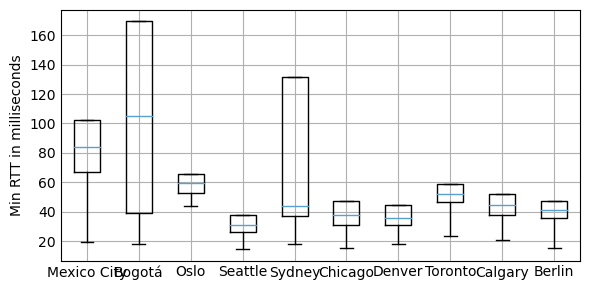

In [15]:
# 2021 - 2022
visualize_boxplot(df, "MinRTT", save=True, usestd=False)

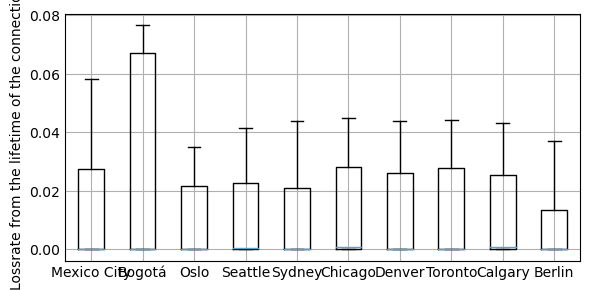

In [16]:
visualize_boxplot(df, "lossrate", save=True)

## MinRTT CDFs

In [17]:
seattle_values

NameError: name 'seattle_values' is not defined

In [18]:
len(xs)

NameError: name 'xs' is not defined

KeyError: 'ClientCity'

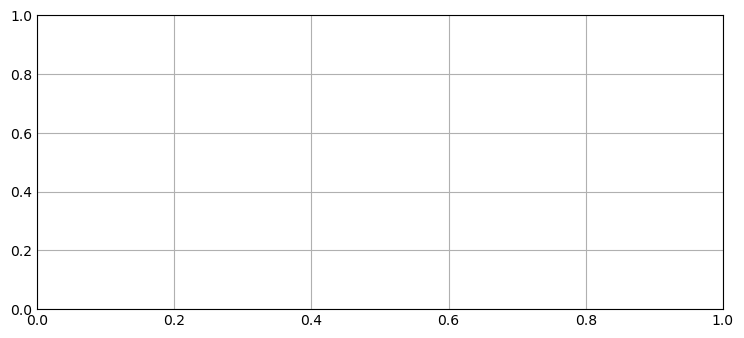

In [19]:
#interesting_cities = [
#                "Mexico City",
#                "Bogotá",
#                "Oslo",
#                "Seattle",
#                "Sydney",
#    
#                "Chicago",
#                "Denver",
#                "Toronto",
#                "Calgary",
#                "Berlin"
#            ]

interesting_cities = [
                "Mexico City",
                "Bogotá",
                "Oslo",
                "Seattle",
                "Sydney"]

continent_colors = {
            "Mexico City" : "#7598b6",
            "Bogotá"      : "#914c09",
            "Oslo"        : "#ce9c7f",
            "Seattle"     : "#c1d5e2", 
            "Sydney"      : "#663979"
                }
lstyles = {
            "Mexico City" : "dotted",
            "Bogotá"      : "solid",
            "Oslo"        : "dashed",
            "Seattle"     : "solid", 
            "Sydney"      : "dashdot"
                }

#interesting_cities = ["Seattle"]

fig, ax = plt.subplots(figsize=(7, 3))
for city in interesting_cities:
    #xs = seattle_values
    #xs = np.sort(list(filter(lambda x: x < 400, tcp_pings[cont]))) # filter out outliers above 400 ms
    xs = df[(df["ClientCity"] == city) & (df["MinRTT"] < 600)]["MinRTT"].values
    xs = sorted(xs)
    ys = np.arange(1, len(xs) + 1) / len(xs)
    indices = []
    current = xs[0]
    for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
        if x != current:
            current = x
            indices.append(i - 1)
    indices.append(len(ys) - 1)
    xs = sorted(set(xs))
    ys = [ys[i] for i in indices]
    ax.plot(xs, ys, label=city, color=continent_colors[city], linestyle=lstyles[city])
    
ax.set_xlabel("MinRTT [ms]")
ax.set_ylabel("Percentile")
ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)
plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

fig.tight_layout()
plt.savefig("cdf_minrtt_5cities.pdf", pad_inches = 0)
plt.show()

KeyError: 'ClientGeohash'

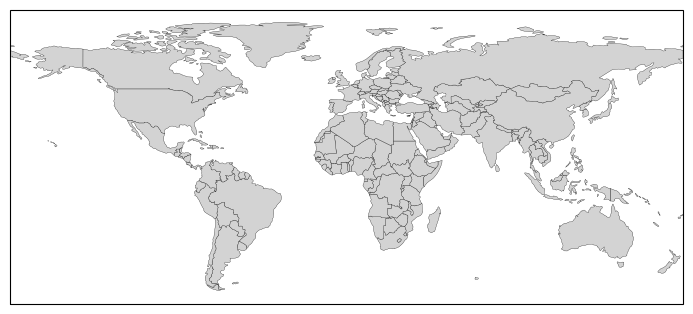

In [20]:
# TODO: dotted map of these interesting cities

import geopandas
from matplotlib import colors
from descartes import PolygonPatch

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]

#def plotCountryPatch( axes, country_name, fcolor ):
#    # plot a country on the provided axes
#    nami = world[world.name == country_name]
#    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
#    namig0 = {'type': namigm[0]['geometry']['type'], \
#              'coordinates': namigm[0]['geometry']['coordinates']}
#    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2, linewidth=0.0 ))


fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

#cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "lightgrey", edgecolor="black", ax=ax, linewidth=0.2)

#for c in countries:
#    c = "United States of America" if c == "United States" else c
#    
#    if(c in world["name"].values):
#        plotCountryPatch(ax, c, cols[2])

points = [geohash.decode(gh) for gh in list(set(df["ClientGeohash"].values))]
points = np.array(points)    
    
latitude, longitude = points[:, 1], points[:, 0]
ax.scatter(latitude, longitude, sizes = [1.0], color="red", zorder = 10)

ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig("mlab_availabilitynprobes.pdf", pad_inches=0)
plt.show()